<a href="https://colab.research.google.com/github/styavit/Collaboratory/blob/main/Imdb_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_words = 10000  # Consider only the top 10,000 most common words
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
print("x_train[0] (first review, word indices):", x_train[0][:15]) # Print first 15 word indices of the first review
print("y_train[0] (label for first review):", y_train[0])

print("Length of x_train:", len(x_train)) # Expected: 25000
print("Length of x_test:", len(x_test))   # Expected: 25000

# Reviews have different lengths
print("Length of first review:", len(x_train[0]))
print("Length of second review:", len(x_train[1]))

# To make sense of the word indices, you can load the word index mapping
word_index = keras.datasets.imdb.get_word_index()

# The word_index maps words to integers. We need to reverse it to map integers to words.
# Indices are offset by 3 because 0 (padding), 1 (start of sequence), 2 (unknown) are reserved.
reverse_word_index = {value + 3: key for key, value in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>" # Unknown word

def decode_review(text_indices):
    return " ".join([reverse_word_index.get(i, "<UNK>") for i in text_indices])

print("\nDecoded first review:")
print(decode_review(x_train[0]))

x_train[0] (first review, word indices): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4]
y_train[0] (label for first review): 1
Length of x_train: 25000
Length of x_test: 25000
Length of first review: 218
Length of second review: 189
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Decoded first review:
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good

In [5]:
maxlen = 256  # Cut reviews after 256 words (or pad shorter ones)

x_train_padded = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test_padded = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

print("\nShape of x_train_padded:", x_train_padded.shape) # Expected: (25000, 256)
print("x_train_padded[0] (first padded review):", x_train_padded[0][:20]) # Show some of the padded sequence


Shape of x_train_padded: (25000, 256)
x_train_padded[0] (first padded review): [   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25]


In [7]:
embedding_dim = 16 # Dimension of the dense embedding

# model = keras.Sequential([
#     layers.Embedding(input_dim=num_words,         # Size of the vocabulary (10,000)
#                      output_dim=embedding_dim,    # Dimension of the dense embedding (16)
#                      input_length=maxlen),        # Length of input sequences (256)

#     # Option 1: Global Average Pooling (simple way to handle variable sequence lengths after embedding)
#     layers.GlobalAveragePooling1D(),

#     # Option 2: Flatten (another way, but can create very large input for Dense layer if embedding_dim * maxlen is large)
#     # layers.Flatten(),

#     layers.Dense(units=32, activation='relu'), # A hidden dense layer
#     layers.Dropout(0.5), # Dropout for regularization
#     layers.Dense(units=1, activation='sigmoid') # Output layer for binary classification (positive/negative)
#                                               # Sigmoid outputs a probability between 0 and 1
# ])

# To use an LSTM (a type of RNN) instead of GlobalAveragePooling1D:
model = keras.Sequential([
    layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
    layers.LSTM(units=32), # An LSTM layer with 32 units
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy', # Loss function for binary classification
              metrics=['accuracy'])

In [9]:
batch_size = 512
epochs = 10

history = model.fit(x_train_padded, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2) # Using 20% of training data for validation

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.4934 - loss: 0.6933 - val_accuracy: 0.5072 - val_loss: 0.6930
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5120 - loss: 0.6929 - val_accuracy: 0.5074 - val_loss: 0.6926
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5219 - loss: 0.6914 - val_accuracy: 0.5392 - val_loss: 0.6904
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5500 - loss: 0.6847 - val_accuracy: 0.5710 - val_loss: 0.6956
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5730 - loss: 0.6665 - val_accuracy: 0.5740 - val_loss: 0.6568
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6030 - loss: 0.6213 - val_accuracy: 0.5984 - val_loss: 0.6223
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6301 - loss: 0.5876 - val_accuracy: 0.5628 - val_loss: 0.6552
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6143 - loss: 0.6045 - val_accuracy: 0.5986 - v

In [10]:
loss, accuracy = model.evaluate(x_test_padded, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Test Loss: 0.6606
Test Accuracy: 0.5795


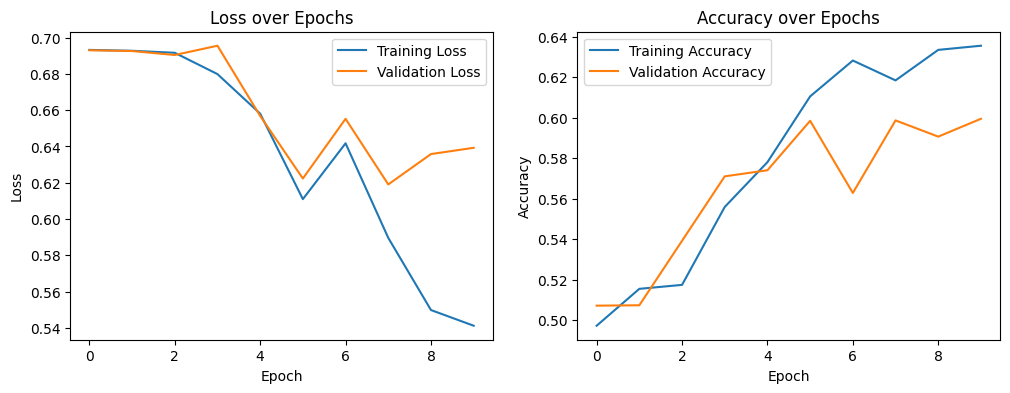

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [12]:
# Example of predicting on a hypothetical new review
# new_reviews_text = ["this movie was fantastic and amazing", "what a terrible and boring film"]
# Preprocessing steps (tokenization, integer encoding using word_index, padding) would be needed here.
# For simplicity, let's just use a few examples from the test set to demonstrate prediction.

predictions = model.predict(x_test_padded[:5]) # Predict on first 5 test reviews
for i in range(5):
    print(f"\nReview (decoded): {decode_review(x_test[i][:50])}...") # Show start of original review
    print(f"True Label: {'Positive' if y_test[i] == 1 else 'Negative'}")
    print(f"Predicted Probability (raw): {predictions[i][0]:.4f}")
    print(f"Predicted Label: {'Positive' if predictions[i][0] > 0.5 else 'Negative'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step

Review (decoded): <START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going...
True Label: Negative
Predicted Probability (raw): 0.4983
Predicted Label: Negative

Review (decoded): <START> this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances <UNK> the sandy dennis character apartment but the film builds to a disturbing climax br br...
True Label: Positive
Predicted Probability (raw): 0.9721
Predicted Label: Positive

Review (decoded): <START> many animation buffs consider <UNK> <UNK> the great forgotten genius of one special branch of the art puppet animation which he invented almost single <UNK> and as it happened almost accide